# Integrated Choice and Latent Variable model (ICLV) [Hybrid Choice Model]

- This notebook was written by Evangelos Paschalidis.
- Acknowledgement of the material is required.
- The codecomes with no guarantees and the author cannot be held liable for any errors.
- Contact: evangelos.paschalidis@epfl.ch

## Overview

This notebook covers the estimation of an ICLV model in python with maximum likelihhod estimation:

* Load necessary packages
* Define variables and parameters to estimate
* Model specification
* Model output

## Context: Mode choice

Imagine the following situation where an individual must choose between three mode alternatives:
* Bus (1)
* Metro (2)
* Car (3)

A typical approach to model such behaviour is via Stated Preference (SP) surveys.

In SP surveys, an individual choses among a number of alternatives in a series of choice tasks

Each alternative is characterised by a number of different attributes such as travel time, travel cost etc.

About indicators:
* In our data we have three variables named as "Attitude".
* The attitudinal questions are used to reflet the impact of the latent variable on them.
* In our example we can consider the attitudes as pro-car statements.
* Example: "I would always prefer car over public transport"
* Typical responses are on Likert scale e.g. 1-Totally disagree, 2, 3, 4, 5-Totally agree.

### Example of a SP survey

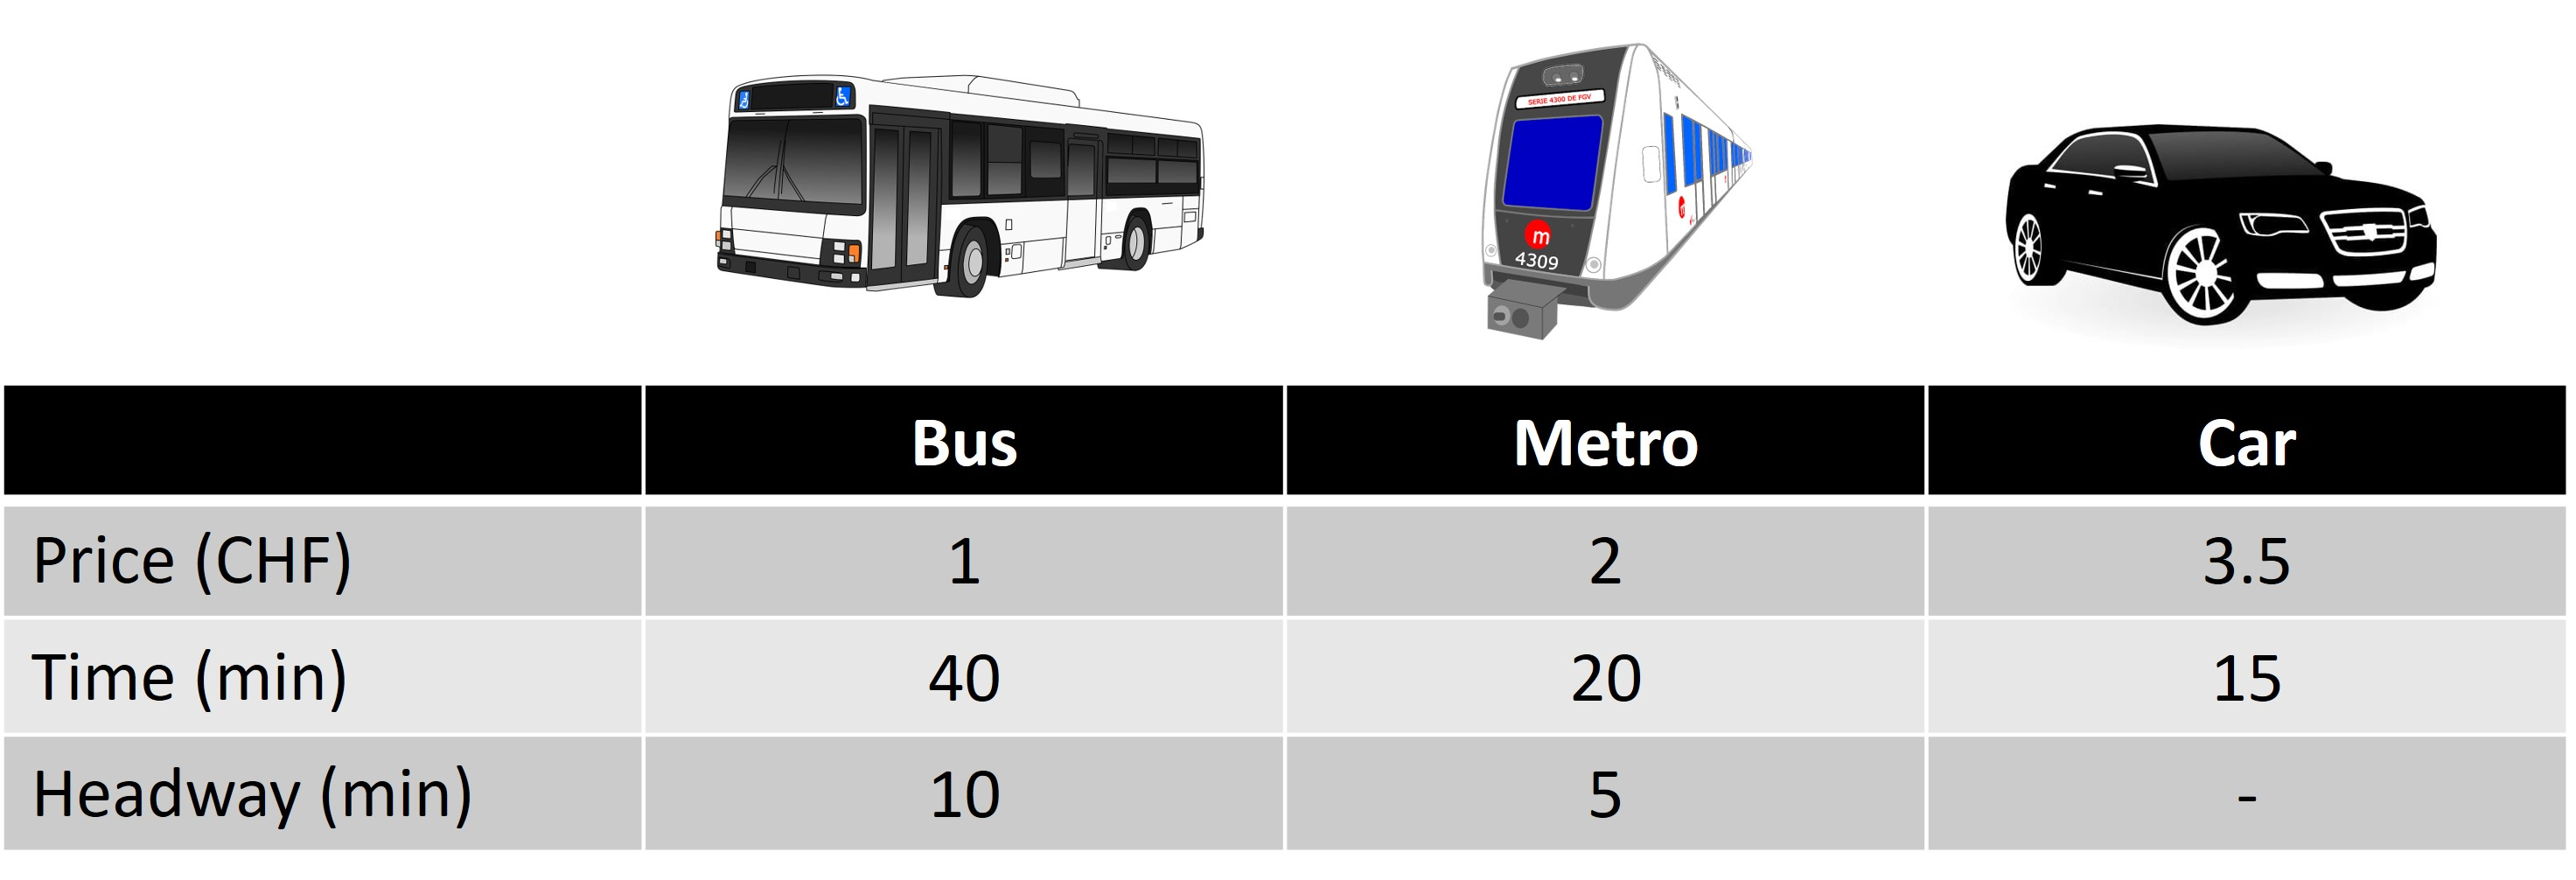

## Model specification

## Load packages

Before we estimate the model let's load some packages that we are going to need. When importing a package, it is common to rename it using an abbreviation.

In [ ]:
import pandas as pd # for data frame processing
import numpy as np # for some statistical procedures
from scipy.optimize import minimize # optimisation routine for parameter estimation
from scipy.stats import norm # normal distribution density function
import numdifftools as nd # we use this to calculate t-ratios and p-values
from scipy.stats import t # we use this to calculate the CFDs needed for t-ratios and p-values
import csv # we need this to store our parameters as csv
from scipy.special import roots_legendre # we use this to generate nodes for numerical integration
from scipy.stats import qmc # we use this to generate nodes for numerical integration
from collections import OrderedDict

### Let's give a name to our model

In [ ]:
model_name = 'ICLV_model' # Name we want to give to our model (this is used when saving the output)

### Panel structure
We need to define whether our data is panel (i.e. multiple observations per individual) or not

In [ ]:
panel = 1 # switch to 1 if data is panel (any other value if not panel)

### Define if we use mixing

In [ ]:
mixing = 1 # switch to 1 if we apply mixing - random effects (any other value if no mixing applied)

## Load the data

Now it is time to load the data. We can do that using the piece of code below.

**Important!** Make sure the data is in the same folder with the notebook file

In [ ]:
# Command to load the data
data = pd.read_table('data_mode_choice_iclv.txt')

# If the data does not have an ID variable we create one
# data['ID'] = range(1, len(data) + 1)

# Number of observations (we need this to caclulate goodness-of-fit indices)
Nobs = data.shape[0]

#### We add a task index (we need this for the indicators probabilities later)

In [ ]:
data['task_index'] = data.groupby('ID').cumcount() + 1

## Print the data

Let's quickly print the data. Simply type *data* in the field below

(If we open our data set with a different name e.g. *database* then the latter should be used)

* Please make sure to change the name througout the whole script if you change the data frame name.

In [ ]:
# Type "data" in this field (without the quotation) and run the cell (Shift + return)
data

## Print the variable names (columns)

We can also print the variable names only using the piece of code below

* This is useful during model specification to easily access the column names

In [ ]:
print(data.columns)

## Variable definition

We need to define the variables (as numpy arrays) that we will use in our model.

* The arrays can have any name but it is more convenient to use the same name as in the data set.
* The *".reshape(-1, 1)"* is not necessary now but it is required if we include mixing (random effects) in our model.
    * Reshape allows to multiply arrays of different dimensions.

##### Define explanatory (independent) variables

In [ ]:
# Example variable_name = np.array(data['variable_name']).reshape(-1, 1)

choice = np.array(data['Choice']).reshape(-1, 1)
tt_bus = np.array(data['Bus_travel_time']).reshape(-1, 1)
tt_metro = np.array(data['Metro_travel_time']).reshape(-1, 1)
tt_car = np.array(data['Car_travel_time']).reshape(-1, 1)
tc_bus = np.array(data['Bus_travel_cost']).reshape(-1, 1)
tc_metro = np.array(data['Metro_travel_cost']).reshape(-1, 1)
tc_car = np.array(data['Car_travel_cost']).reshape(-1, 1)
hw_bus = np.array(data['Bus_headway_time']).reshape(-1, 1)
hw_metro = np.array(data['Metro_headway_time']).reshape(-1, 1)

att1 = np.array(data['Attitude1']).reshape(-1, 1)
att2 = np.array(data['Attitude2']).reshape(-1, 1)
att3 = np.array(data['Attitude3']).reshape(-1, 1)

gender = np.array(data['Gender']).reshape(-1, 1)
age = np.array(data['Age']).reshape(-1, 1)

task_index = np.array(data['task_index']).reshape(-1, 1)

#### Define the whole data set variables
* It may be the case that we have too many variables in the data
* In that case it makes more sense to define all variables instead of doing it individually
* We do that in the code below (activate to use)

In [ ]:
# def attach(df):
#     for col in df.columns:
#         globals()[col] = np.array(df[col]).reshape(-1, 1)

# attach(data)

##### Define the ID variable

In [ ]:
# Example ID = np.array(data['ID']) # ID does not need to be reshaped

ID = np.array(data['ID']) # ID does not need to be reshaped

##### Delete the data frame
*We may want to delete the data frame to preserve some RAM (suggested for very large data sets)*

In [ ]:
# Activate to delete the data frame.
# del[data]

## Model specification

We now need to create a function that includes our model.

* Python functions are defined as: def *function_name*(parameters):
* We end a function as: return *value_to_return*

In the current implementation we specify two different functions as:
* *function 1* calculates the log likelihood per observations
* *function 2* calculates the sum of log likelihood taking as input the result from *function 1*

*We define two different functions to be more flexible in the post estimation processing later in the code*

We use some python (numpy) functions such '*exp*' or '*log*'. To execute these in the current example, we need to also call numpy; hence, we have *np.exp()* and *np.log()*.

### Define parameters and starting values

Ultimately, we want to estimate the value of some parameters that maximise the likelihood of our observations of the dependent variable.

Before starting the estimation process, we need to define some starting values for the parameters to be estimated. The typecal starting value is zero.

In [ ]:
betas_start = {"asc_bus": 0, "asc_metro": 0, "beta_tc": 0, "beta_tt": 0, "beta_hw": 0
                ,"beta_gender_bus":0, "beta_age_bus":0,"beta_gender_metro":0, "beta_age_metro":0
              , "beta_lv_bus":0, "beta_lv_metro":0, "sigma_bus":0, "sigma_metro":0
               ,"gamma_gender":0, "gamma_age":0
               , "zeta_ind1":1, "zeta_ind2":1, "zeta_ind3":1
               , "tau_1_1": -2,"tau_1_2":-1,"tau_1_3": 1,"tau_1_4":2
               , "tau_2_1": -2,"tau_2_2":-1,"tau_2_3": 1,"tau_2_4":2
               , "tau_3_1": -2,"tau_3_2":-1,"tau_3_3": 1,"tau_3_4":2
              }

### Load old parameter estimates results

Sometimes, we want to use results from old models as starting values.
* To do that, we will load the iteration file from a previous estimation
* Please note that only values of parameters with same names with our current model will be copied

In [ ]:
# ### Activate this cell to load old results ###

# # Open old iteration file
# betas_old = pd.read_csv('model_name_iterations.csv')

# # Keep last row
# betas_old = betas_old.tail(1)

# # Convert to dictionary
# betas_old = betas_old.to_dict(orient='records')[0]

# # Copy values from old to start for keys that are common to both dictionaries
# for key in betas_old:
#     if key in betas_start:
#         betas_start[key] = betas_old[key]

# # Delete old estimates
# del[betas_old]

#### Method 2: Code for simulation
The simulation code will generate uniform random numbers (0, 1).

In [ ]:
# First let's set the number of draws
Ndraws = 100

In [ ]:
# This piece of code is generating Halton draws using the number of nodes we set just above

# It may be the case that even though data is panel (i.e. each ID is repeated multiple times)...
# ... we still want cross-sectional estimation. For that we need a little tweak in the ID variable
if panel==0:
    ID = np.array(range(1, len(data) + 1))

nIndiv = len(set(ID))
draws = ['draws_lv','draws_bus','draws_metro']
nDim = len(draws)
tasks = (pd.DataFrame(ID).value_counts(sort = False)) # observations per ID

sampler = qmc.Halton(d=nDim, scramble=False)
sample = pd.DataFrame(sampler.random(n=Ndraws*nIndiv+Ndraws))
sample = sample[(Ndraws-1):(Ndraws*nIndiv+Ndraws-1)]

cols = len(sample.columns)

for i in range(cols):
    # print(i)
    sample1 = np.array(sample.loc[:,i])
    sample1=pd.DataFrame(np.reshape(sample1,(nIndiv,Ndraws)))
    sample_rep =sample1.loc[sample1.index.repeat(tasks)]
    globals()[draws[i]] = sample_rep

#### Here we convert the uniform draws to the target distribution

In [ ]:
# Convert to normal distribution (or any other preferred)
# Example for normal distribution: draws_param1 = norm.ppf(draws_param1)

draws_lv = norm.ppf(draws_lv)
draws_bus = norm.ppf(draws_bus)
draws_metro = norm.ppf(draws_metro)

### We add the ordered logit function to use for modelling the probabilities of the indicators

In [ ]:
def OL(Y,X,taus):
        
        taus = np.concatenate([[-np.inf], taus, [np.inf]])
        
        p_ol = (1/(1 + np.exp(X-taus[Y])) - 1/(1 + np.exp(X-taus[Y-1])))**(taus[Y]>taus[Y-1])
        
        return p_ol

### Function 1: log likelihood (LL)
This function calculates the log likelihood per observation

In [ ]:
def LL(betas): # betas is a vector with the parameters we want to estimate
   
    # First let's define the parameters to be estimated.
    # The parameter names are imported directly from 'beta_start' that we defined earlier
    
    for pn in range(len(betas_start.values())):
        globals()[np.array(list(betas_start.keys()))[pn]] = betas[pn]

    ############################################################################################################
    ############################################################################################################

    # First of all let us define the latent variables

    lv_car_support = gamma_gender*gender + gamma_age*age + draws_lv
    
    ############################################################################################################
    ############################################################################################################
    
    # We need to define the utility functions
    # Please make sure that you are using the same names for the parameters as those defined in 'betas_start'
    
    # First we create a dictionary for mapping the alternatives
    alts = OrderedDict([("bus", (choice==1)), ("metro", (choice==2)), ("car", (choice==3))])
    
    # Then we set availabilities
    av = OrderedDict([("av_bus", 1), ("av_metro", 1), ("av_car", 1)])
    
    # First we create an empty dictionary to store the utility functions
    Utility = {}
    
    # Then we add the utility functions per mode
    Utility["U_bus"] = (asc_bus + beta_tc * tc_bus + beta_hw * hw_bus
                         + beta_tt * tt_bus + sigma_bus*draws_bus
                       + beta_gender_bus*gender + beta_age_bus*age + beta_lv_bus*lv_car_support)
    Utility["U_metro"] = (asc_metro + beta_tc * tc_metro + beta_hw * hw_metro
                          + beta_tt * tt_metro + sigma_metro*draws_metro
                         + beta_gender_metro*gender + beta_age_metro*age + beta_lv_metro*lv_car_support)
    Utility["U_car"] = (beta_tc * tc_car + beta_tt * tt_car)
    
    def logit(Utility,alts,av):
        # Take the exp of utilities
        Utility = {key: np.exp(value) for key, value in Utility.items()}
        
        # Apply availabilities
        Utility_av = [v1 * v2 for (_, v1), (_, v2) in zip(Utility.items(), av.items())]
        Utility = dict(zip(Utility.keys(), Utility_av))
        del(Utility_av)
        
        # Take sum of utilities
        Usum = sum(Utility.values())
        
        # Calculate probabilities
        Utility = {key: value / Usum for key, value in Utility.items()}
        
        # Calculate probabilities
        Utility_p = [v1 * v2 for (_, v1), (_, v2) in zip(Utility.items(), alts.items())]
        Utility = dict(zip(Utility.keys(), Utility_p))
        del(Utility_p)
        
        # Take sum of utilities
        plogit = sum(Utility.values())
        
        return plogit
    
    P_choice = logit(Utility,alts,av)

    ############################################################################################################
    ############################################################################################################

    # We need to work the indicator probabilities now

    # Indicator 1
    V_ind1 = zeta_ind1*lv_car_support # Impact of the latent variable on the indicator
    taus1 = np.array([tau_1_1,tau_1_2,tau_1_3,tau_1_4]) # Ordered logit thresholds
    P_ind1 = OL(att1,V_ind1,taus1)**(task_index==1) # Probability (we use task_index==1 to consider the indicator probability only once per individual)

    # Indicator 2
    V_ind2 = zeta_ind2*lv_car_support
    taus2 = np.array([tau_2_1,tau_2_2,tau_2_3,tau_2_4])
    P_ind2 = OL(att2,V_ind2,taus2)**(task_index==1)

    # Indicator 3
    V_ind3 = zeta_ind3*lv_car_support
    taus3 = np.array([tau_3_1,tau_3_2,tau_3_3,tau_3_4])
    P_ind3 = OL(att3,V_ind3,taus3)**(task_index==1)

    # Total indicator probability
    P_ind = P_ind1*P_ind2*P_ind3

    ############################################################################################################
    ############################################################################################################

    # Total probability (we combile the choice probability with the indicators probabilities)
    
    P = P_choice * P_ind
    
    ############################################################################################################
    ############################################################################################################
    # - Now this below is relevant if we have panel data and apply mixing (Do not change this piece of code!) -#
    if panel == 1:
    # Do it as panel
        P = pd.DataFrame(P)
        P = pd.concat([pd.Series(ID), pd.DataFrame(P)], axis=1, ignore_index=True)
        P.rename(columns={P.columns[0]: 'ID'},inplace=True)
    
        # We take the product of probabilities per individual per draw and then delete the ID column
        P = P.groupby('ID', as_index=False).prod()
        P = P.drop('ID', axis=1)
   
    if mixing == 1:
        # We take the average per row to get the average probability per individual (if mixing == 1)
        
        if panel == 1:
            P['mean'] = P.mean(axis=1)
            P = np.array(P['mean'])
        
        if panel == 0:
            P = pd.DataFrame(P)
            P = pd.concat([pd.Series(ID), pd.DataFrame(P)], axis=1, ignore_index=True)
            P.rename(columns={P.columns[0]: 'ID'},inplace=True)
    
            # We take the product of probabilities per individual per draw and then delete the ID column
            P = P.groupby('ID', as_index=False).prod()
            P = P.drop('ID', axis=1)
            P['mean'] = P.mean(axis=1)
            P = np.array(P['mean'])
            
    P = np.array(P)
    ### --- This is where the panel data approach ends. --- ###
    ############################################################################################################
    ############################################################################################################
    
    # We then take the log of the density function
    logprob = np.log(P)
    
    return logprob

### Function 2: sum of log likelihood (SLL)
This function simply takes the sum of log likelihood that we calculated with the first function

In [ ]:
def SLL(betas):
    return -sum(LL(betas))

## Model estimation

### Warnings

Sometimes, optimisation procedures may 'overdo' it with warnings during estimation.
We can supress these with the piece of code below (not always advisable)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Estimation

Now it is finally time to run our estimation command.
We use an optimisation algorith called 'BFGS'.

**Do not to edit the lines of code below (except optimisation routine if needed).**

In [ ]:
# This will give us the initial loglikelihood value as an output
def callback1(betas):
    print("Current log likelihood:", -SLL(betas))

# This function will allow as to store parameter estimates during iterations
# Initialise list to store parameter values
parameter_values = [np.array(list(betas_start.values()))]
# Then define the function
def callback2(betas):    
    parameter_values.append(betas)
    column_names = list(betas_start.keys())
    with open(f'{model_name}_iterations.csv','w',newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(column_names)
        writer.writerows(parameter_values)

# Now let's combine the two callback functions
def combined_callback(betas):
    callback1(betas)
    callback2(betas)
        
print("Initial log likelihood:", -SLL(np.array(list(betas_start.values()))))

# Choose optimisation routine (preferably BFGS)
optimiser = 'BFGS' # BFGS or L-BFGS-B or nelder-mead

result = minimize(SLL, np.array(list(betas_start.values())), method=optimiser,callback=combined_callback, 
                  options={'disp':False})

print("Final log likelihood:", -result.fun)

## Post estimation processing

We evaluate our parameter estimates using t-ratios (or p-Values).

In maximum likelihood estimation, we extract these from the variance-covariance matrix of the parameters.

The variance covariance matrix is not readily available but we need to calculate it.

This is done with the code below.

**DO NOT EDIT THE CHUNK OF CODE BELOW!**

In [ ]:
# Vector of parameter estimates
parameters = result['x'] 

# Calculate hessian
print("Calculating Hessian, please wait (this may take a while...)")
Hess = nd.Hessian(SLL, method = 'forward')
hessian = Hess(parameters)
inv_hessian = np.linalg.inv(hessian)

# Parameter statistics
dof = Nobs - len(betas_start) - 1
se = np.sqrt(np.diag(inv_hessian)) # Standard errors
tratio = parameters/se # t-ratios
p_value = (1-t.cdf(np.abs(tratio),dof)) * 2 # p-values


# --- Sandwich estimator --- #

# The sandwich estimator provides the "robust" s.e., t-ratios and p-values.
# These should be preferred over the classical parameter statistics.

# We first need the gradients at the solution point
Grad = nd.Gradient(LL, method = 'forward')
gradient = Grad(parameters)

# Then we need to calculate the B matrix
B = np.array([])
for r in range(gradient.shape[0]):
    Bm = np.zeros([len(betas_start),len(betas_start)])
    gradient0 = gradient[r,:]
    for i in range(len(gradient0)):
            for j in range(len(gradient0)):
                element = gradient0[i]*gradient0[j]
                Bm[i][j] = element
    if B.size==0:
                    B = Bm
    else:
                    B = B+Bm

# Finally we "sandwich" the B matrix between the inverese hessian matrices
BHHH = (inv_hessian)@(B)@(inv_hessian)

print("... Done!!")

# Now it is time to calculate some "robust" parameter statistics
rob_se = np.sqrt(np.diag(BHHH)) # robust standard error
rob_tratio = parameters/rob_se # robust t-ratio
rob_p_value = (1-t.cdf(np.abs(rob_tratio),dof)) * 2 # robust p-value

## Results
Finally, we got our results. Let's print them!

The outputs that we receive are:
* Estimates: These are the values of our parameters. We must check if the sign is consistent with our expectations
* s.e.: Standard errors of the parameters
* tratio: t-ratio of the parameters (significant if absolute value > 1.96)
* p_value: p-value of the parameters (significant if < 0.05)

The parameter statistics also have their **robust** versions. These should be preferred as they are less susceptible to weakly specified models.

In [ ]:
arrays = np.column_stack((np.array(list(betas_start.keys())),parameters,se,tratio,p_value,rob_se,rob_tratio,rob_p_value))
results = pd.DataFrame(arrays, columns = ['Parameter','Estimate','s.e.','t-ratio0','p-value',
                                          'Rob s.e.','Rob t-ratio0','Rob p-value'])

results[['Estimate','s.e.','t-ratio0','p-value','Rob s.e.','Rob t-ratio0','Rob p-value']] = (
results[['Estimate','s.e.','t-ratio0','p-value','Rob s.e.','Rob t-ratio0','Rob p-value']].apply(pd.to_numeric, errors='coerce'))
numeric_cols = results.select_dtypes(include='number').columns
results[numeric_cols] = results[numeric_cols].round(3)
results # print results

## Goodness-of-fit indices

Let's calculate some goodness-of-fit indices now (do not edit)

In [ ]:
# First let's calculate the GoF indices

rho_squared = 1 - ((-result.fun)/(-SLL(np.zeros(len(betas_start)))))
adj_rho_squared = 1 - (((-result.fun)-len(betas_start))/(-SLL(np.zeros(len(betas_start)))))

AIC = 2*len(betas_start) - 2*(-result.fun)
BIC = len(betas_start)*np.log(Nobs) - 2*(-result.fun)

LL0t = "Log likelihood at zeros:" + str(-SLL(np.zeros(len(betas_start))))
LLinit = "Initial log likelihood:" + str(-SLL(np.array(list(betas_start.values()))))
LLfin = "Final log likelihood:" + str(-result.fun)

rs1 = "rho squared="+str(rho_squared)
rs2 = "adjusted rho squared="+str(adj_rho_squared)
ac = "AIC="+str(AIC)
bc = "BIC="+str(BIC)

# Then let's print the GoF indices

print(LL0t)
print(LLinit)
print(LLfin)

print(rs1)
print(rs2)
print(ac)
print(bc)

## Save output

We can save our output using the code below (do not edit):

In [ ]:
with open(f"{model_name}_results.txt", 'w') as f:
    f.write(f'{LL0t}\n')
    f.write(f'{LLinit}\n')
    f.write(f'{LLfin}\n')
    f.write(f'{rs1}\n')
    f.write(f'{rs2}\n')
    f.write(f'{ac}\n')
    f.write(f'{bc}\n')
    results.to_csv(f, index=False, sep='\t')
results.to_csv(f'{model_name}_results.csv', index=False)

np.savetxt(f'{model_name}_varcovar.csv', inv_hessian, delimiter=",") # save variance-covariance matrix
np.savetxt(f'{model_name}_rob_varcovar.csv', BHHH, delimiter=",") # save robust variance-covariance matrix